In [5]:
!pip install transformers

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class Neural_Network():
    def __init__(self, neurons, Activations, initialization='randn'):
        """Define the NN design parameters
        Args:
            neurons (int array): list of number of neurons in each layer
            Activations (str array): list of activations to be used for hidden and output layers
            initialization (str, optional): Choose weight initialization from
             uniform or normal distribution. Defaults to 'randn'.
        """

        self.inputSize = neurons[0] # Number of neurons in input layer
        self.outputSize = neurons[-1] # Number of neurons in output layer
        self.layers = len(neurons)
        self.weights = [] # weights for each layer
        self.biases = [] # biases in each layer
        self.layer_activations = [] # activations for each layer

        if initialization == 'rand':
            self.initializer = np.random.rand
        elif initialization == 'randn':
            self.initializer = np.random.randn
        else:
           raise ValueError("initialization must be 'rand' or 'randn' or 'he' or 'xavier'")
        for i in range(len(neurons)-1):
            self.weights.append(self.initializer(neurons[i+1],neurons[i])*0.1) # weight matrix between layer i and layer i+1
            self.biases.append(self.initializer(neurons[i+1],1)*0.1)
            self.layer_activations.append(Activations[i]) # activations for each layer


    def sigmoid(self, z):
        """Returns result of the sigmoid activation function on input z."""
        return 1.0 / (1.0 + np.exp(-z))
    
    def sigmoidPrime(self, z):
        """Returns derivative of sigmoid activation function applied on input z."""
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def tanh(self, z):
        """Transforms values to -1 to 1"""
        return np.tanh(z)
    
    def tanhPrime(self, z):
        """Returns derivative of hyperbolic tan activation function applied on input z."""
        return 1 - np.tanh(z)**2
    
    def linear(self, z):
        """Returns result of the linear activation function on input z."""
        return z
    
    def linearPrime(self, z):
        """Returns derivative of linear activation function applied on input z."""
        return np.ones_like(z)
    
    def ReLU(self, z):
        """Returns result of the ReLU activation function on input z."""
        return np.maximum(0, z)
    
    def reluPrime(self, z):
        """Returns derivative of ReLU activation function applied on input z."""
        return np.where(z > 0, 1, 0)
    
    def softmax(self, z):
        """Returns result of the softmax activation function on input z."""
        e_z = np.exp(z - np.max(z, axis=0))  # Subtract max for numerical stability
        return e_z / np.sum(e_z, axis=0)

    def lossSE(self, predicted, actual):
        """Implementation of Squared-error loss function."""
        return 0.5 * np.mean(np.sum((predicted - actual)**2, axis=0))
    
    def lossCE(self, predicted, actual):
        """Implementation of Cross-Entropy loss function."""
        epsilon = 1e-15  # To avoid log(0)
        return -np.mean(np.sum(actual * np.log(predicted + epsilon), axis=0))



    def forward(self, x):
        
        layer_activations_a = [x]  # Store the outputs of activation
        a = x  # Storing input as activation of zero-th layer
        layer_dot_prod_z = []
        for i, param in enumerate(zip(self.biases, self.weights)):
            b, w = param[0], param[1]
            
            # Compute z as the weighted sum of inputs plus bias
            z = np.dot(w, a) + b
            
            if self.layer_activations[i].lower() == 'sigmoid':
                a = self.sigmoid(z)
            elif self.layer_activations[i].lower() == 'relu':
                a = self.ReLU(z)
            elif self.layer_activations[i].lower() == 'tanh':
                a = self.tanh(z)
            elif self.layer_activations[i].lower() == 'linear':
                a = self.linear(z)
            elif self.layer_activations[i].lower() == 'softmax':
                a = self.softmax(z)
            layer_dot_prod_z.append(z)
            layer_activations_a.append(a)
        return a, layer_dot_prod_z, layer_activations_a


    def backward(self, x, y, zs, activations):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
        # Output layer delta calculation
        delta = (activations[-1] - y)
        if self.layer_activations[-1].lower() == 'softmax':
            delta_z = delta
        else:
            activation_prime = getattr(self, self.layer_activations[-1].lower() + 'Prime')
            delta_z = delta * activation_prime(zs[-1])
        
        # Average gradients over batch dimension
        grad_b[-1] = np.mean(delta_z, axis=1, keepdims=True)  # Changed from direct assignment
        grad_w[-1] = np.dot(delta_z, activations[-2].T) / x.shape[1]
        
        # Hidden layers backpropagation
        for l in range(2, self.layers):
            current_z = zs[-l]
            activation_prime = getattr(self, self.layer_activations[-l].lower() + 'Prime')
            delta_z = np.dot(self.weights[-l+1].T, delta_z) * activation_prime(current_z)
            
            # Average gradients over batch dimension
            grad_b[-l] = np.mean(delta_z, axis=1, keepdims=True)  # Changed from direct assignment
            grad_w[-l] = np.dot(delta_z, activations[-l-1].T) / x.shape[1]
            
        return (grad_b, grad_w)


    def update_parameters(self, grads, lr):
        
        grad_b, grad_w = grads[0], grads[1]
        
        # Update weights and biases using gradient descent
        for i in range(len(self.weights)):
            self.weights[i] -= lr * grad_w[i]
            self.biases[i] -= lr * grad_b[i]


    def error(self, X, Y, errors):
        """Appends loss to error list"""
        y = np.squeeze(self.forward(X)[0])
        errors.append(self.loss(y, Y))

    def copy_params(self):
        """Returns a copy of current NN parameters"""
        weights = [w.copy() for w in self.weights]
        biases = [b.copy() for b in self.biases]
        return (weights, biases)
    

    def train(self, X, Y, lr = 1e-3, max_epochs = 1000, patience=5, batch_size = None,
              n_classes=10, onehotencoded=False, loss_func='SE', Xval=None, Yval=None, verbose=True):


        if onehotencoded:
            # a method for creating one hot encoded labels
            def onehotencoding(Y, n):
                """Convert labels to one-hot encoded format.
                
                Args:
                    Y (array): labels
                    n (int): number of classes
                    
                Returns:
                    array: one-hot encoded labels
                """
                
                # Create a matrix of zeros with shape (n, len(Y))
                one_hot = np.zeros((n, Y.shape[0]))
                
                # Set the corresponding indices to 1
                one_hot[Y.astype(int), np.arange(Y.shape[0])] = 1
                
                return one_hot


            Y = onehotencoding(Y, n_classes)
            if Yval is not None:
                Yval = onehotencoding(Yval, n_classes)

        # Below code ensures that Y is 2-dimensional even when one-hot encoding is not
        # performed, so our same code works for training NN for both tasks.
        Y = np.expand_dims(Y,0) if len(Y.shape) == 1 else Y
        Yval = np.expand_dims(Yval,0) if (Yval is not None and len(Yval.shape) == 1) else Yval

        if loss_func == 'SE':
            self.loss = self.lossSE
        elif loss_func == 'CE':
            self.loss = self.lossCE

        train_errors=[]
        if Xval is not None:
            val_errors=[]
        i, j, v = 0, 0, np.inf     ## i -> epoch, j->patience, v ->best loss
        best_params = self.copy_params()

        if batch_size is not None:
            if batch_size > len(X[0]):
                raise ValueError("invalid mini-batch size. Must be smaller than dataset length")
        else:   ## if batch_size is not given
            batch_size = len(X[0])

        #LR control function

        if isinstance(lr, (float, int)):# constant Ir arg is passed to train get_ir lambda x: 1r # we return a function object which returns the same ir at every epoc elif callable(lr): # function in arg is passed to train
           get_lr =lambda X: lr # the function is then used to get in for a particular epoch else: raise ValueError('param Ir can only be a number or a scheduler function")
        elif callable(lr):
          get_lr =lr
        else:
          raise ValueError('param lr can only be a number or a scheduler function')



        while j < patience:

            # Shuffle dataset
            indices = np.random.permutation(X.shape[1])
            X_shuffled = X[:, indices]
            Y_shuffled = Y[:, indices]
            
            # Train in mini-batches
            for start_idx in range(0, X.shape[1], batch_size):
                end_idx = min(start_idx + batch_size, X.shape[1])
                X_batch = X_shuffled[:, start_idx:end_idx]
                Y_batch = Y_shuffled[:, start_idx:end_idx]
                
                # Forward pass
                a, zs, activations = self.forward(X_batch)
                
                # Backward pass
                grads = self.backward(X_batch, Y_batch, zs, activations)
                
                # Update parameters
                self.update_parameters(grads, get_lr(i))
            
            i += 1  # increment epoch count

            self.error(X, Y, train_errors)   ### appending the loss to train_errors
            if Xval is not None:
                self.error(Xval, Yval, val_errors)    ## appending the val_loss to errors

                if val_errors[-1] < v:
                    j = 0 # reset patience counter
                    v = val_errors[-1] # update best loss
                    best_params = self.copy_params() # save params
                else:
                    j += 1 # increment patience counter

            if verbose and i%5 == 0:
                log = f"Epoch {i}..............Loss on train = {train_errors[-1]}"
                if Xval is not None:
                    log += f", Loss on val = {val_errors[-1]}"
                print(log)

            if i >= max_epochs:
                break # stop if epoch threshold crossed

        if Xval is not None:
            if i >= max_epochs and verbose:
                print("Reached Epoch Cap without convergence....Terminating")
            elif verbose:
                print("Early Stopping .............. Returning best weights")

            self.weights, self.biases = best_params # reset to best params

        if verbose:
            x = np.arange(1, len(train_errors)+1)
            plt.plot(x, train_errors, label="Loss on Train")
            if Xval is not None:
                plt.plot(x, val_errors, label="Loss on Val")
            plt.legend()
            plt.title(f"{loss_func} - Learning Rate = {lr}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.show()
        if Xval is not None:
            return (train_errors, val_errors)
        return train_errors

    def predict(self, x):
        """Predicts output for the given input
        
        Args:
            x (array): input data
            
        Returns:
            array: predictions
        """
        return (self.forward(x)[0])
        
        # For binary classification
        # if self.outputSize == 1:
        #     return (self.forward(x)[0] > 0.5).astype(int)
        
        # # For multi-class classification
        # else:
        #     return np.argmax(self.forward(x)[0], axis=0)



In [4]:
import pandas as pd
from pathlib import Path
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split



data_dir = Path('/kaggle/input/fake-new-detection-dataset-mi')
df_trn = pd.read_csv(data_dir/'train.csv')
df_val = pd.read_csv(data_dir/'valid.csv')
df_tst = pd.read_csv(data_dir/'test.csv')

df_trn['labels'] = df_trn['labels'].map({'true': 1, 'fake': 0})
df_val['labels'] = df_val['labels'].map({'true': 1, 'fake': 0})
df_tst['labels'] = df_tst['labels'].map({'true': 1, 'fake': 0})


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

def tokenize_texts(texts, tokenizer, max_len=128):
    encoded = tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors=None  # Return NumPy-ready lists
    )
    return np.array(encoded['input_ids'])  # [N, max_len]

X_train = tokenize_texts(df_trn['text'], tokenizer, max_len)
X_test = tokenize_texts(df_tst['text'], tokenizer, max_len)

# Binary labels: make sure they're in shape [N, 1]
y_train = df_trn['labels'].values.reshape(-1, 1)
y_test = df_tst['labels'].values.reshape(-1, 1)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Epoch 5..............Loss on train = 0.31426695409912014
Epoch 10..............Loss on train = 0.3138431851778294
Epoch 15..............Loss on train = 0.31018170612718343
Epoch 20..............Loss on train = 0.29263965157963695
Epoch 25..............Loss on train = 0.27555957843917817
Epoch 30..............Loss on train = 0.24166671496962866
Epoch 35..............Loss on train = 0.22440580638437374
Epoch 40..............Loss on train = 0.21268624957762805
Epoch 45..............Loss on train = 0.1891401847452183
Epoch 50..............Loss on train = 0.18780763311425602
Epoch 55..............Loss on train = 0.18495792937566574
Epoch 60..............Loss on train = 0.18447917224611995
Epoch 65..............Loss on train = 0.1841376772450459
Epoch 70..............Loss on train = 0.18287423219393745
Epoch 75..............Loss on train = 0.18212292000791122
Epoch 80..............Loss on train = 0.1818014015120382
Epoch 85..............Loss on train = 0.18202557212322137
Epoch 90...........

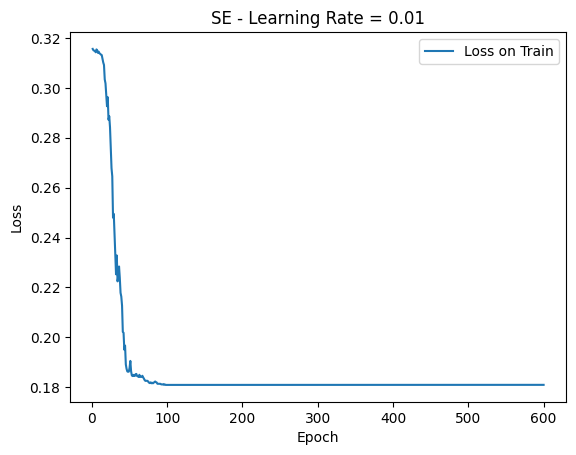

[0 0 0 ... 0 0 0]
[[1]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]
0.2013607066125567


In [31]:
if __name__ == "__main__":
    
    # Create network
    nn = Neural_Network(neurons=[128, 64, 64, 1], 
                       Activations=['relu','relu', 'sigmoid'],
                       initialization='randn')
    
    # Train network
    nn.train(X_train.T, y_train.T, lr=0.01, max_epochs=600, verbose=True)
    
    # Test predictions
    Predictions = nn.predict(X_test.T)
    final_predictions = np.where(Predictions[0]>0.5, 1, 0)
    print(final_predictions)
    print(y_test)
    acc = 0
        
    for i in range(len(final_predictions)):
        if (y_test[i][0] == final_predictions[i]):
            acc += 1
    print(acc/len(final_predictions))

# from nnfs.datasets import spiral_data
# import nnfs
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Initialize the dataset (fixes the random seed for reproducibility)
# nnfs.init()

# # Load spiral data
# X, y = spiral_data(samples=1000, classes=3)

# # Split into train/test (80/20 split)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# # Transpose since your neural net expects shape (features, samples)
# X_train, X_test = X_train.T, X_test.T
# y_train, y_test = y_train.T, y_test.T


# # Train the network
# nn = Neural_Network(neurons=[2, 16, 16, 3], 
#                     Activations=['relu', 'relu', 'sigmoid'],
#                     initialization='randn')

# nn.train(X_train, y_train, lr=0.1, max_epochs=500, verbose=True)

# # Predict on test set
# predictions = nn.predict(X_test)
# # print(predictions)

# # Convert softmax/sigmoid output to class predictions
# predicted_classes = np.argmax(predictions, axis=0)
# true_classes = y_test.flatten()

# # print(predicted_classes)
# # print(true_classes)

# # Accuracy
# accuracy = accuracy_score(true_classes, predicted_classes)
# print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


In [26]:
Predictions = nn.predict(X_test.T)
final_predictions = np.where(Predictions[0]>0.5, 1, 0)
print(final_predictions)
print(y_test)
acc = 0
    
for i in range(len(final_predictions)):
    if (y_test[i][0] == final_predictions[i]):
        acc += 1
print(acc/len(final_predictions))


[0 0 0 ... 0 0 0]
[[1]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]
0.2013607066125567
